<a href="https://colab.research.google.com/github/arshiabagchi/Face-Recognition-/blob/main/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAKING DATASET

In [152]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [154]:
dataset_dir = '/content/drive/My Drive/dataset'

In [151]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os

# Function to take a photo
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    print(f"Photo saved as {filename}")
    return filename

# Function to create a folder for a person
def create_person_folder(person_name):
    folder_name = f"dataset/{person_name}"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

# Function to validate the dataset (ensure each label has at least one image)
def validate_dataset(dataset_dir):
    # List all folders, but skip hidden folders (those starting with a dot)
    class_names = sorted([f for f in os.listdir(dataset_dir) if not f.startswith('.')])

    for person_name in class_names:
        person_folder = os.path.join(dataset_dir, person_name)

        # Skip if it's not a directory (just to be sure)
        if not os.path.isdir(person_folder):
            continue

        # Check if there are image files in the folder
        image_files = [f for f in os.listdir(person_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

        if len(image_files) == 0:
            print(f"Warning: {person_name} has no valid image files.")
        else:
            print(f"{person_name} has {len(image_files)} images.")



# Main function to capture labeled photos
def capture_labeled_photos():
    # Create a main folder for the dataset
    if not os.path.exists("dataset"):
        os.makedirs("dataset")

    while True:
        # Ask for the person's name (label)
        person_name = input("Enter the person's name (or 'q' to quit): ").strip()
        if person_name.lower() == 'q':
            print("Exiting...")
            break

        # Create a folder for the person
        person_folder = create_person_folder(person_name)
        print(f"Capturing photos for {person_name}. Press 'Capture' in the browser to take photos.")

        # Capture at least one photo for this person
        photo_count = 0
        while True:
            # Capture a photo
            photo_filename = os.path.join(person_folder, f"{person_name}_{photo_count}.jpg")
            take_photo(photo_filename)
            print(f"Photo saved as {photo_filename}")
            photo_count += 1


            # Ask if the user wants to capture another photo
            another = input("Capture another photo? (y/n): ").strip().lower()
            if another != 'y':
                print(f"Finished capturing photos for {person_name}.")
                break

# Run the main function to capture labeled photos
capture_labeled_photos()

# After capturing photos, validate the dataset
validate_dataset("dataset")

Enter the person's name (or 'q' to quit): q
Exiting...
Arshia has 3 images.
aruv has 5 images.
harshita has 4 images.
kashish has 4 images.


# TRAIN AND TEST

In [153]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Path to your dataset
dataset_dir = "dataset"

# List folders (skip hidden folders like .ipynb_checkpoints)
class_names = sorted([f for f in os.listdir(dataset_dir) if not f.startswith('.')])

# Print the class names (person names) to ensure they are in the correct order
print("Class names (labels):", class_names)

# Initialize lists to store images and labels
# Initialize lists to store images and labels
images = []
labels = []

# Loop through each person's folder and load images
for label, person_name in enumerate(class_names):
    person_folder = os.path.join(dataset_dir, person_name)

    if os.path.isdir(person_folder):
        # Sort the images in the folder to ensure correct order
        image_files = sorted([f for f in os.listdir(person_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))])

        if len(image_files) > 0:
            for image_name in image_files:
                image_path = os.path.join(person_folder, image_name)
                # Load the image and resize it (e.g., 128x128)
                image = load_img(image_path, target_size=(128, 128))
                image = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
                images.append(image)
                labels.append(label)
        else:
            print(f"Warning: {person_name} has no valid image files.")
    else:
        print(f"Warning: {person_name} is not a valid directory or is empty.")

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Verify label-image alignment after loading the dataset
for i in range(5):  # Checking first 5 images and their labels
    print(f"Image {i}: Label = {labels[i]} -> {class_names[labels[i]]}")


# Perform a stratified split to ensure all classes are represented in both training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# After splitting, print a few label-name pairs from the training set
for i in range(5):  # Checking first 5 images and their labels
    print(f"Training image {i}: Label = {train_labels[i]}, Name = {class_names[train_labels[i]]}")

# Print shapes of the datasets
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)




Class names (labels): ['Arshia', 'aruv', 'harshita', 'kashish']
Image 0: Label = 0 -> Arshia
Image 1: Label = 0 -> Arshia
Image 2: Label = 0 -> Arshia
Image 3: Label = 1 -> aruv
Image 4: Label = 1 -> aruv
Training image 0: Label = 0, Name = Arshia
Training image 1: Label = 2, Name = harshita
Training image 2: Label = 3, Name = kashish
Training image 3: Label = 0, Name = Arshia
Training image 4: Label = 2, Name = harshita
Training images shape: (12, 128, 128, 3)
Training labels shape: (12,)
Testing images shape: (4, 128, 128, 3)
Testing labels shape: (4,)


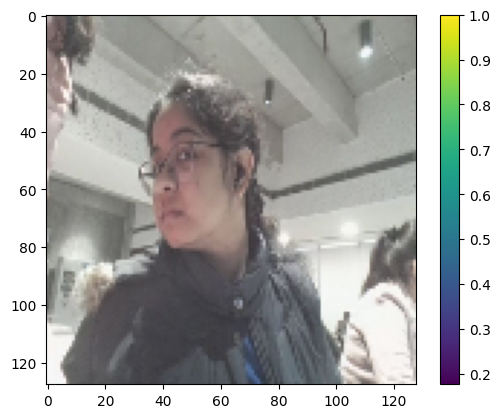

In [159]:
import matplotlib.pyplot as plt

# Display an image from the training dataset
plt.figure()
plt.imshow(train_images[1])  # RGB images do not need cmap='gray'
plt.colorbar()
plt.grid(False)
plt.show()


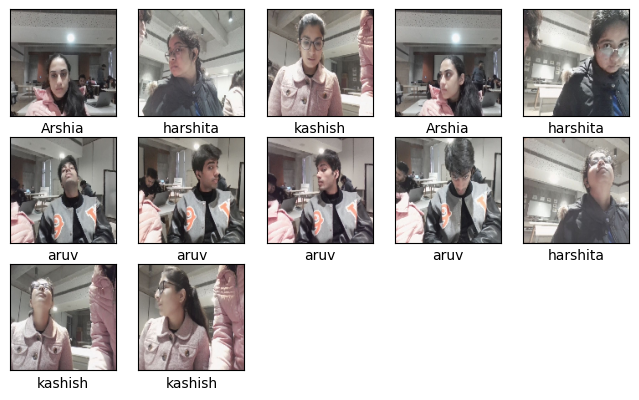

In [160]:
import matplotlib.pyplot as plt

num_images = len(train_images)  # Get the number of available images

plt.figure(figsize=(8, 8))  # Adjust figure size
for i in range(num_images):  # Loop through only existing images
    plt.subplot(5,5, i + 1)  # Create a 2x2 grid (since you have 4 images)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])  # Display the image
    plt.xlabel(class_names[train_labels[i]])  # Show person's name

plt.show()

# import matplotlib.pyplot as plt

# # Visualize a few random images
# num_images = 6  # You can adjust the number of images to show
# fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# for i in range(num_images):
#     ax = axes[i]
#     image = train_images[i]  # Use training images (or test_images)
#     label = train_labels[i]  # Use training labels (or test_labels)

#     ax.imshow(image)
#     ax.set_title(class_names[label])  # Map label to class name
#     ax.axis('off')  # Hide axis for better visualization

# plt.show()


In [161]:
import tensorflow as tf
from tensorflow import keras

# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(128, 128, 3)),  # Flatten 128x128 RGB images into a 1D vector
#     keras.layers.Dense(128, activation='relu'),  # Hidden layer with 128 neurons
#     keras.layers.Dense(len(class_names), activation='softmax')  # Output layer (number of classes = number of people)
# ])

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(class_names), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [162]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [163]:
model.fit(train_images, train_labels, epochs=20, validation_split=0.2)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4444 - loss: 1.3630 - val_accuracy: 0.0000e+00 - val_loss: 5.3817
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4444 - loss: 2.6435 - val_accuracy: 0.3333 - val_loss: 2.3469
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step - accuracy: 0.8889 - loss: 1.0141 - val_accuracy: 0.0000e+00 - val_loss: 1.8423
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step - accuracy: 0.8889 - loss: 1.0751 - val_accuracy: 0.0000e+00 - val_loss: 1.4928
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7778 - loss: 0.8905 - val_accuracy: 0.0000e+00 - val_loss: 2.0488
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4444 - loss: 0.9844 - val_accuracy: 0.0000e+00 - val_loss: 1.6670
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8889 - loss: 0.6049 - val_accuracy: 0.3333 - val_loss: 1.8971
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8889 - loss: 0.5943 - val_accuracy: 0.3333 - val_

In [164]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print('Test accuracy:', test_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7500 - loss: 0.4611
Test accuracy: 0.75


In [165]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

# Function to capture a photo
def take_photo(filename='captured_photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    print(f"Photo saved as {filename}")
    return filename


# PREDICT

<IPython.core.display.Javascript object>

Photo saved as captured_photo.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Predicted probabilities: [[0.26153117 0.5347404  0.11703248 0.08669591]]


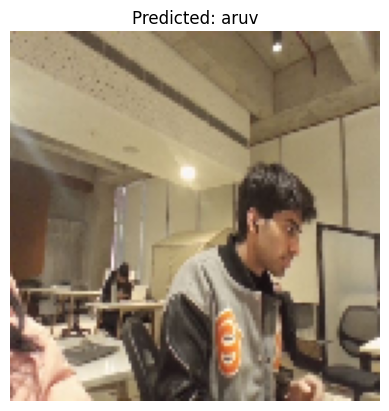

In [166]:

# Function to preprocess the captured image
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(128, 128))
    image = img_to_array(image) / 255.0
    return image


def predict_face(model, image, class_names):
    prediction = model.predict(np.array([image]))  # Shape: (1, num_classes)
    print("Predicted probabilities:", prediction)  # Check the raw predictions
    predicted_class_index = np.argmax(prediction)  # Get index of highest probability
    predicted_class = class_names[predicted_class_index]
    return predicted_class

# Function to display the result
def show_face(image, predicted_class):
    plt.figure()
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# Step 1: Capture a photo
captured_image_path = take_photo()

# Step 2: Preprocess the captured image
captured_image = preprocess_image(captured_image_path)

# Step 3: Predict the face
predicted_class = predict_face(model, captured_image, class_names)

# Step 4: Display the result
show_face(captured_image, predicted_class)